In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Chapter 1

In [2]:
from spacy.lang.en import English

In [3]:
nlp = English()
doc = nlp("Hello World!")
for token in doc:
  print(token.text)

Hello
World
!


In [4]:
# Indexing the document to get a single token
token = doc[1]
print(token.text)

World


In [5]:
# A slice from the document is a Span object
span = doc[1:3]
print(span.text)

World!


# Lexical Attributes

In [6]:
doc = nlp("It costs $5.")

In [7]:
print("Index: ", [token.i for token in doc])
print("Text: ", [token.text for token in doc])

print("is_alpha: ", [token.is_alpha for token in doc])
print("is_punct: ", [token.is_punct for token in doc])
print("like_num: ", [token.like_num for token in doc])

Index:  [0, 1, 2, 3, 4]
Text:  ['It', 'costs', '$', '5', '.']
is_alpha:  [True, True, False, False, False]
is_punct:  [False, False, False, False, True]
like_num:  [False, False, False, True, False]


In [8]:
# Checking percentages and returning the number
doc = nlp(
    "In 1990, more than 60% of people in East Asia were in extreme poverty."
    "Now less than 4% are."
)

for token in doc:
  if token.like_num:  # if token is a number, get the next token
    next_token = doc[token.i + 1]
    if next_token.text == "%":
      print("Percentage found: ", token.text)


Percentage found:  60
Percentage found:  4


# Statistical Models

Statistical models enable spaCy to predict linguistic attributes in context, like whether a word is a verb or a word is a person's name:
- Part-of-speech tags
- Syntactic dependencies
- Named entities

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")  # small English model with all core capabilities and is trained on web text
# - Binary weights
# - Vocabulary
# - Meta information (language, pipeline)

Predicting Part-of-Speech tags

In [10]:
doc = nlp("She ate the pizza.")

for token in doc:
  print(token.text, token.pos_)

She PRON
ate VERB
the DET
pizza NOUN
. PUNCT


In [11]:
for token in doc:
  print(token.text, token.pos_, token.dep_, token.head.text)

She PRON nsubj ate
ate VERB ROOT ate
the DET det pizza
pizza NOUN dobj ate
. PUNCT punct ate


The .dep_ returns the predicted dependency label.

The .head returns the syntactic head token, like the parent token the word is attached to.

What is a dependency label?

The dependency label scheme looks like this:
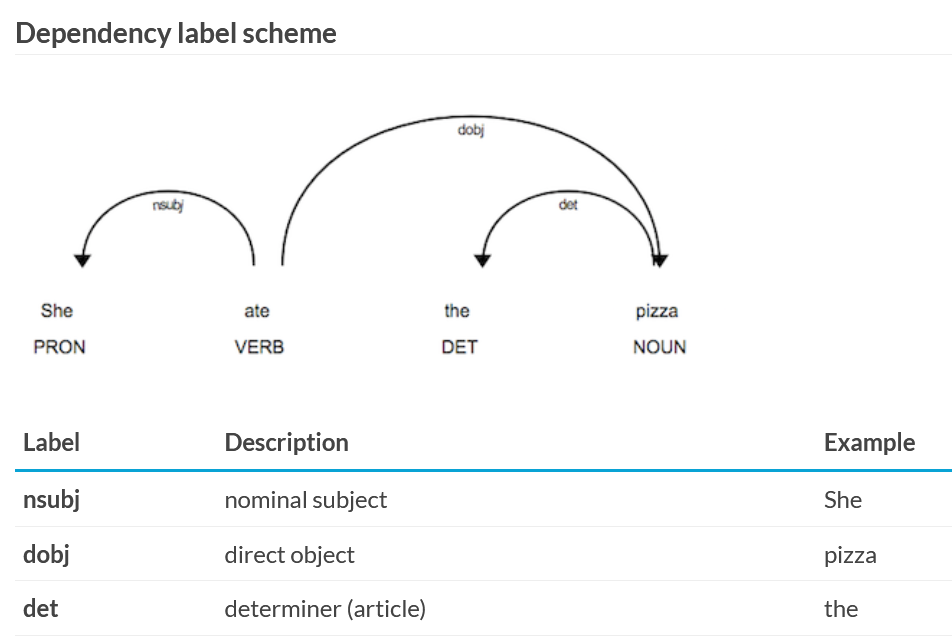

Predicting Named Entities

Named entities are real-world objects that are assigned a name - person, company, country etc.

doc.ents returns a Span of objects which are the named entities that the model predicts. Using the .label_ attribute, we can get the entity name.

In [12]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for ent in doc.ents:
  print(ent.text, ent.label_)

Apple ORG
U.K. GPE
$1 billion MONEY


Spacy can also explain the named entity in several more words.

In [13]:
spacy.explain("GPE")

'Countries, cities, states'

In [14]:
spacy.explain("NNP")

'noun, proper singular'

In [15]:
spacy.explain("dobj")

'direct object'

However, spaCy can also make wrong predictions, or totally miss out words that have entities.

In [16]:
text = "Upcoming iPhone X release date leaked as Apple reveals pre-orders"

doc = nlp(text)
for ent in doc.ents:
  print(ent.text, ent.label_)

iphone_x = doc[1:3]
print("Missing entity: ", iphone_x.text)

Apple ORG
Missing entity:  iPhone X


When that is the case, we can use spaCy's matcher which lets you write rules to find words/texts.

# Rule-based matching

In [17]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
# Initialize the matcher with the shared vocab
matcher = Matcher(nlp.vocab)

In [18]:
pattern = [{"TEXT": "iPhone"}, {"TEXT": "X"}]
# First arg: unique ID to identify the pattern
# Second arg: callback - unnecessary here
# Third arg: pattern to match
matcher.add("IPHONE_PATTERN", None, pattern)

In [19]:
doc = nlp("Upcoming iPhone X release date leaked")
matches = matcher(doc)
print(matches)

[(9528407286733565721, 1, 3)]


In [20]:
for match_df, start, end in matches:
  matched_span = doc[start:end]
  print(matched_span.text)

iPhone X




---



In [21]:
pattern = [
           {"IS_DIGIT": True},
           {"LOWER": "fifa"},
           {"LOWER": "world"},
           {"LOWER": "cup"},
           {"IS_PUNCT": True}
]

matcher.add("FIFA_PATTERN", None, pattern)

doc = nlp("2018 FIFA World Cup: France won!")
matches = matcher(doc)
for match_id, start, end in matches:
  matched_span = doc[start:end]
  print(matched_span.text)

2018 FIFA World Cup:




---



In [22]:
pattern = [
           {"LEMMA": "love", "POS": "VERB"},
           {"POS": "NOUN"}
]

matcher.add("TEMP_PATTERN", None, pattern)

doc = nlp("I loved dogs but now I love cats more")
matches = matcher(doc)
for match_id, start, end in matches:
  matched_span = doc[start:end]
  print(matched_span.text)

loved dogs
love cats




---



In [23]:
pattern = [
           {"LEMMA": "buy"},
           {"POS": "DET", "OP": "?"},   # Operators (refer below)
           {"POS": "NOUN"}
]

matcher.add("TEMP_PATTERN", None, pattern)

doc = nlp("I bought a smartphone. Now I'm buying apps.")
matches = matcher(doc)
for match_id, start, end in matches:
  matched_span = doc[start:end]
  print(matched_span.text)

bought a smartphone
buying apps


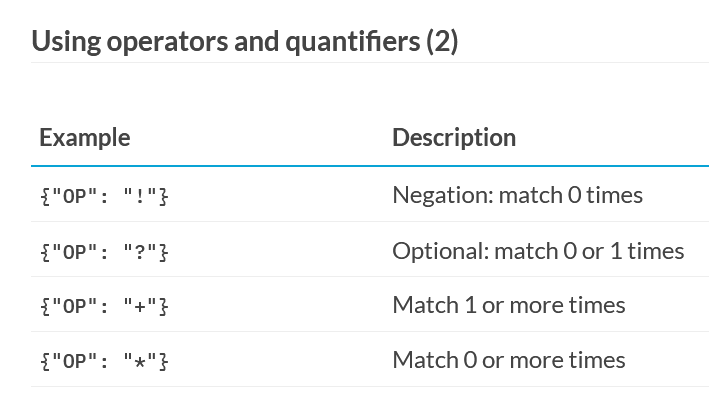

# Chapter 2: Large-scale data analysis

# Vocabs, hashes and lexemes

In [24]:
nlp.vocab.strings.add("coffee")

coffee_hash = nlp.vocab.strings['coffee']
coffee_string = nlp.vocab.strings[coffee_hash]

print("Coffee hash: ", coffee_hash)

string = nlp.vocab.strings[3197928453018144401]
print(string)

Coffee hash:  3197928453018144401
coffee




---



In [25]:
doc = nlp("I love coffee")
print("Hash value: ", nlp.vocab.strings['coffee'])
print("String value: ", nlp.vocab.strings[3197928453018144401])

Hash value:  3197928453018144401
String value:  coffee


In [26]:
# Using the doc to expose the strings
print("Hash value: ", doc.vocab.strings['coffee'])

Hash value:  3197928453018144401




---



A `Lexeme` object is a context-independent entry in the vocabulary


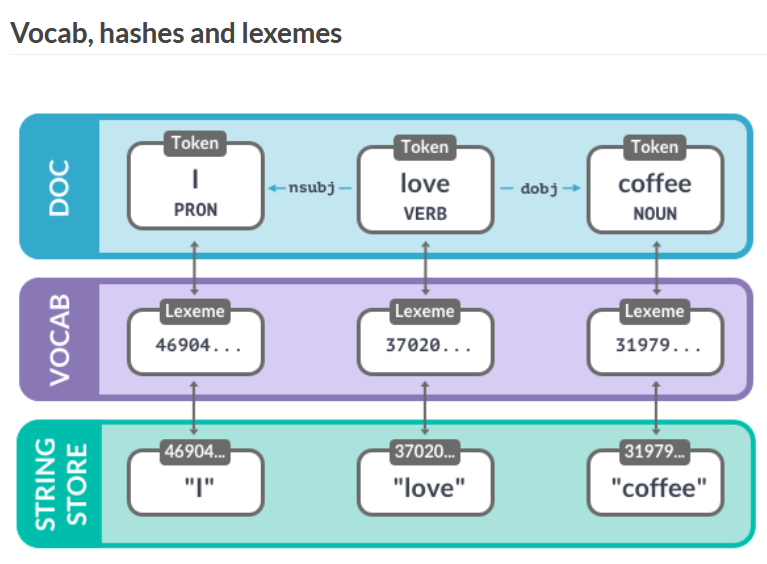

In [27]:
doc = nlp("I love coffee")
lexeme = nlp.vocab['coffee']

print(lexeme.text, lexeme.orth, lexeme.is_alpha)

coffee 3197928453018144401 True


# Data structures: Doc, token and span

In [28]:
from spacy.tokens import Doc

nlp = English()
words = ['Hello', 'world', '!']
spaces = [True, False, False]   # Indicates whether there is a space following each token, even the last one

# Doc is a central data structure in spaCy
# Automatically created with the nlp object, 
# But a document can be manually created using this Doc object
# Takes in 3 parameters:
# - the shared vocab
# - the words
# - the spaces
doc = Doc(nlp.vocab, words=words, spaces=spaces)

In [29]:
from spacy.tokens import Doc, Span

words = ['Hello', 'World', '!']
spaces = [True, False, False]

doc = Doc(nlp.vocab, words=words, spaces=spaces)

span = Span(doc, 0, 2)

span_with_label = Span(doc, 0, 2, label='GREETING')

doc.ents = [span_with_label]  # doc.ents are writable 
print(doc.ents)
print([(ent.text, ent.label_) for ent in doc.ents])

(Hello World,)
[('Hello World', 'GREETING')]


# Best practices

In [30]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Berlin looks like a nice city")

for token in doc:
  if token.pos_ == "PROPN":
    if doc[token.i + 1].pos_ == "VERB":
      result = token
      print("Found proper noun before a verb: ", result)

Found proper noun before a verb:  Berlin


# Word vectors and semantic similarity

`Doc.similarity`,` Span.similarity`, `Token.similarity`

Similarity score - 0 to 1

* Takes a model that has word vectors included:
- en_core_web_md
- en_core_web_lg
- XXX en_core_web_sm XXX (does not include word vectors)

1. Similarity is determined using `word vectors`
2. Generated using an algorithm like Word2Vec
3. Can be added to spaCy's statistical models
4. Default: `cosine similarity`, but can be adjusted
5. Short phrases are better than long documents with many irrelevant words

In [31]:
!python -m spacy download en_core_web_md 

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [32]:
nlp = spacy.load('en_core_web_md')

doc1 = nlp("I like fast food")
doc2 = nlp("I like pizza")
print(doc1.similarity(doc2))

0.8627204117787385


In [34]:
doc = nlp("I like pizza and pasta")
token1 = doc[2]
token2 = doc[4]

print(token1.similarity(token2))

0.7369546


# Comparing a document with a token

In [35]:
doc = nlp("I like pizza")
token = nlp("soap")[0]

print(doc.similarity(token))

0.32531983166759537


Comparing a span with a document

In [36]:
span = nlp("I like pizza and pasta")[2:5]
doc = nlp("McDonalds sells burgers")

print(span.similarity(doc))

0.6199092090831612


There is no objective definition of "similarity"

In [38]:
doc1 = nlp("I like cats")
doc2=  nlp("I hate cats")
print(doc1.similarity(doc2))

0.9501447503553421


# Word vectors

In [37]:
doc = nlp("I have a banana")
print(doc[3].vector)

[ 2.0228e-01 -7.6618e-02  3.7032e-01  3.2845e-02 -4.1957e-01  7.2069e-02
 -3.7476e-01  5.7460e-02 -1.2401e-02  5.2949e-01 -5.2380e-01 -1.9771e-01
 -3.4147e-01  5.3317e-01 -2.5331e-02  1.7380e-01  1.6772e-01  8.3984e-01
  5.5107e-02  1.0547e-01  3.7872e-01  2.4275e-01  1.4745e-02  5.5951e-01
  1.2521e-01 -6.7596e-01  3.5842e-01 -4.0028e-02  9.5949e-02 -5.0690e-01
 -8.5318e-02  1.7980e-01  3.3867e-01  1.3230e-01  3.1021e-01  2.1878e-01
  1.6853e-01  1.9874e-01 -5.7385e-01 -1.0649e-01  2.6669e-01  1.2838e-01
 -1.2803e-01 -1.3284e-01  1.2657e-01  8.6723e-01  9.6721e-02  4.8306e-01
  2.1271e-01 -5.4990e-02 -8.2425e-02  2.2408e-01  2.3975e-01 -6.2260e-02
  6.2194e-01 -5.9900e-01  4.3201e-01  2.8143e-01  3.3842e-02 -4.8815e-01
 -2.1359e-01  2.7401e-01  2.4095e-01  4.5950e-01 -1.8605e-01 -1.0497e+00
 -9.7305e-02 -1.8908e-01 -7.0929e-01  4.0195e-01 -1.8768e-01  5.1687e-01
  1.2520e-01  8.4150e-01  1.2097e-01  8.8239e-02 -2.9196e-02  1.2151e-03
  5.6825e-02 -2.7421e-01  2.5564e-01  6.9793e-02 -2

# Combining models and rules

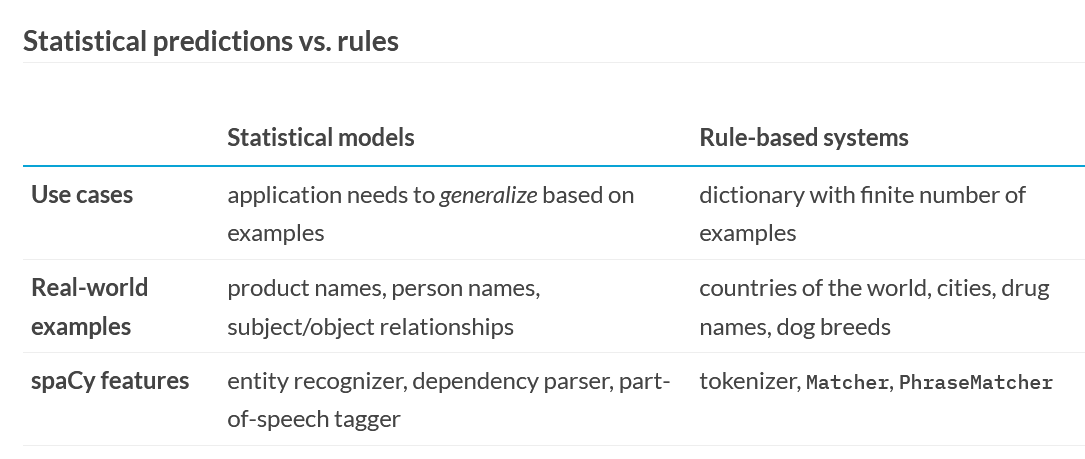

In [39]:
matcher = Matcher(nlp.vocab)
matcher.add("DOG", None, [{"LOWER": "golden"}, {"LOWER": "retriever"}])
doc = nlp("I have a Golden Retriever")

for match_id, start, end in matcher(doc):
  span = doc[start:end]
  print("Matched span: ", span.text)
  print("Root token: ", span.root.text)
  print("Root head token: ", span.root.head.text)
  print("Previous token: ", doc[start-1].text, doc[start-1].pos_)

Matched span:  Golden Retriever
Root token:  Retriever
Root head token:  have
Previous token:  a DET


`PhraseMatcher` finds phrases in the document faster than `Matcher`.
- Takes `Doc` object as patterns

In [40]:
from spacy.matcher import PhraseMatcher

matcher = PhraseMatcher(nlp.vocab)

pattern = nlp("Golden Retriever")
matcher.add("DOG", None, pattern)
doc = nlp("I have a Golden Retriever")

for match_id, start, end in matcher(doc):
  span = doc[start:end]
  print("Matched span: ", span.text)

Matched span:  Golden Retriever


# Chapter 3: Processing Pipelines

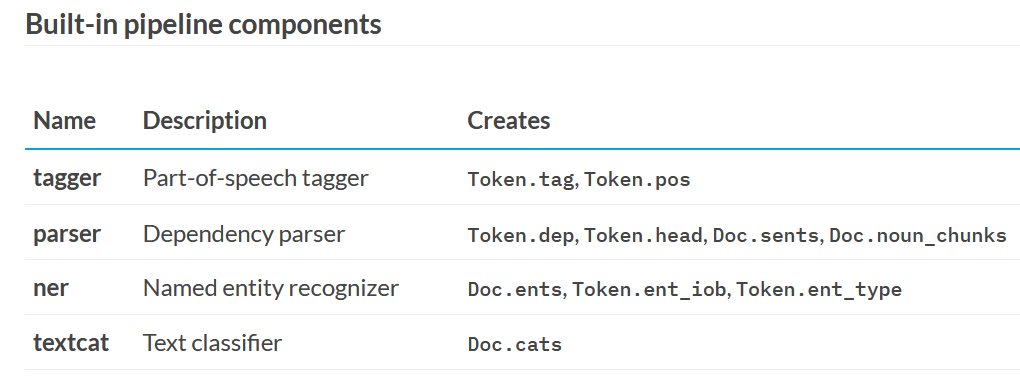

When an NLP object is called on a document, the 
- tagger -> 
- parser -> 
- named entity recognizer -> 
- text classifier pipeline 

is run on the document before returning all the attributes.

In [42]:
print(nlp.pipe_names)
print(nlp.pipeline)

['tagger', 'parser', 'ner']
[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7f7d777d16d0>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7f7d768371a0>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7f7d76837360>)]


# Custom Pipeline

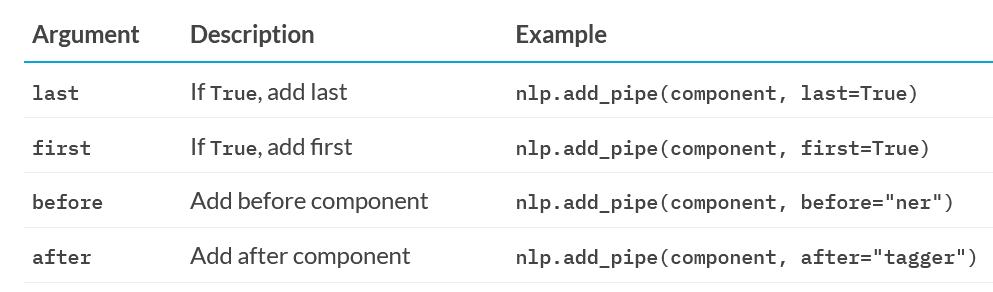

In [43]:
def custom_component(doc):
  print("Doc length: ", len(doc))
  return doc

nlp.add_pipe(custom_component, first=True)
print("Pipeline: ", nlp.pipe_names)

Pipeline:  ['custom_component', 'tagger', 'parser', 'ner']


In [44]:
doc = nlp("Hello World!")

Doc length:  3




---



In [45]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")
animals = ['Golden Retriever', 'cat', 'turtle', 'Rattus norvegicus']
animal_patterns = list(nlp.pipe(animals))
print("Animal patterns: ", animal_patterns)

matcher = PhraseMatcher(nlp.vocab)
matcher.add("ANIMAL", None, *animal_patterns)

def animal_component(doc):
  matches = matcher(doc)
  spans = [Span(doc, start, end, label='ANIMAL') for match_id, start, end in matches]
  doc.ents = spans
  return doc

nlp.add_pipe(animal_component, after="ner")
print(nlp.pipe_names)

doc = nlp("I have a cat and a Golden Retriever")
print([(ent.text, ent.label_) for ent in doc.ents])

Animal patterns:  [Golden Retriever, cat, turtle, Rattus norvegicus]
['tagger', 'parser', 'ner', 'animal_component']
[('cat', 'ANIMAL'), ('Golden Retriever', 'ANIMAL')]


# Extension attributes

Custom attributes are accessible via the `._` property

In [ ]:
# doc._.title = "My Document"
# token._.is_color = True
# span._.has_color = False

In [ ]:
from spacy.tokens import Doc, Token, Span
Doc.set_extension("title", default=None)
Token.set_extension("is_color", default=False)
Span.set_extension("has_color", default=False)

1. Attribute extensions

In [46]:
from spacy.tokens import Token

Token.set_extension("is_color", default=False)
doc = nlp("The sky is blue.")
doc[3]._.is_color = True

2. Property extensions

In [48]:
from spacy.tokens import Token

def get_is_color(token):
  colors = ['red', 'yellow', 'blue']
  return token.text in colors

Token.set_extension("is_color", getter = get_is_color, force = True)

doc = nlp("The sky is blue.")
print(doc[3]._.is_color, " - ", doc[3].text)

True  -  blue


`Span` extensions should almost always use a getter method

In [49]:
from spacy.tokens import Span

def get_has_color(span):
  colors = ['red', 'yellow', 'blue']
  return any(token.text in colors for token in span)

Span.set_extension("has_color", getter=get_has_color, force=True)

doc = nlp("The sky is blue.")
print(doc[1:4]._.has_color, " - ", doc[1:4].text)
print(doc[0:2]._.has_color, " - ", doc[0:2].text)

True  -  sky is blue
False  -  The sky


3. Method extensions

Lets you pass arguments to the extension function

In [50]:
from spacy.tokens import Doc

def has_token(doc, token_text):
  in_doc = token_text in [token.text for token in doc]
  return in_doc

Doc.set_extension("has_token", method=has_token)

doc = nlp("The sky is blue.")
print(doc._.has_token("blue"), " - blue")
print(doc._.has_token("cloud"), " - cloud")

True  - blue
False  - cloud


# Scaling and Performance

When processing large volumes of text, use `nlp.pipe`

In [ ]:
# docs = list(nlp.pipe(LOTS_OF_TEXT))

Setting `as_tuples=True` on `nlp.pipe` lets you pass in (text, context) and yields (doc, context) tuples - useful for associating metadata.

In [51]:
data = [
        ("This is a text", {"id": 1, "page_number": 15}),
        ("And another text", {"id": 2, "page_number": 16})
]

for doc, context in nlp.pipe(data, as_tuples=True):
  print(doc.text, context['page_number'])

This is a text 15
And another text 16


Setting attributes

In [52]:
Doc.set_extension("id", default=None)
Doc.set_extension("page_number", default=None)

for doc, context in nlp.pipe(data, as_tuples=True):
  doc._.id = context['id']
  doc._.page_number = context['page_number']

Let's say we want to use only the tokenizer instead of running the entire pipeline on the document, use this:

In [54]:
doc = nlp.make_doc("Hello World!")

Or disabling pipelines

In [53]:
with nlp.disable_pipes("tagger", "parser"):
  doc = nlp(text)
  print(doc.ents)

()


# Training the NLP model

1. Loop for a number of times
2. Shuffle the training data
3. Divide the data into batches
4. Update the model for each batch
5. Save the updated model

Example:

In [55]:
TRAINING_DATA = [
                 ("How to preorder the iPhone X", {"entities": [(20, 28, "GADGET")]})
                  # many more...
]                 

In [ ]:
import random

for i in range(10):
  random.shuffle(TRAINING_DATA)
  for batch in spacy.util.minibatch(TRAINING_DATA):
    texts = [text for text, annotation in batch]
    annotations = [annotation for text, annotation in batch]
    nlp.update(texts, annotations)

# nlp.to_disk(path_to_model)

Updating an existing model

In [ ]:
nlp = spacy.blank("en")
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)

ner.add_label("GADGET")

# Start training
nlp.begin_training()
for itn in range(10):
  random.shuffle(examples)
  for batch in spacy.util.minibatch(examples, size=2):
    texts = [text for text, annotation in batch]
    annotations = [annotation for text, annotation in batch]
    nlp.update(texts, annotations)

Training Best Practices

Problem 1: Models can forget

Solution: Add in previous training data

BAD

In [ ]:
TRAINING_DATA = [
                 ("Reddit is a website", {"entities": [(0, 6, "WEBSITE")]})
]

GOOD

In [ ]:
TRAINING_DATA = [
                 ("Reddit is a website", {"entities": [(0, 6, "WEBSITE")]}),
                 ("Obama is a person", {"entities": [(0, 5, "PERSON")]})
]

Problem 2: Models can't learn everything

Solution: Labels need to be consistent and not too specific. The surrounding words are most important for local context.

BAD

In [ ]:
LABELS = ['ADULT_SHOES', 'CHILDREN_SHOES', 'BANDS']

GOOD

In [ ]:
LABELS = ['CLOTHING', 'BAND']